In [1]:
import gym
import gym.wrappers
from gym.wrappers import RecordEpisodeStatistics
import os
from Algorithms import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Health_Env
from Health_Env import *

In [2]:
env = gym.make('HealthcareEnv-v0')

In [3]:
# Hyperparameters
state_size = 3
action_size = env.action_space.n
learning_rate = 0.001
epsilon = 1.0
epsilon_decay = 0.995
final_epsilon = 0.01
gamma = 0.99
n_episodes = 1000  
batch_size = 64

In [4]:
QLagent = HealthQLearnVFA(env, learning_rate, epsilon, epsilon_decay, final_epsilon, gamma)

In [5]:
nenv = RecordEpisodeStatistics(env, deque_size=n_episodes)

In [6]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [12]:
budget_queue = []
for episode in tqdm(range(n_episodes)):
    observation, info = nenv.reset()
    done = False
    while not done:
        action = QLagent.policy(observation)
        s_prime, reward, terminated, truncated, info = nenv.step(action = action)
        QLagent.update(observation, action, reward, s_prime)
        done = terminated or truncated
        observation = s_prime
    QLagent.decay_epsilon()
    budget_queue.append(reward)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 82.63it/s]


In [15]:
def plt_results_(env, agent_, w):
    sns.set_theme(style="whitegrid")
    rewards = conv(np.array(env.return_queue).flatten(), win=w)
    lengths = conv(np.array(env.length_queue).flatten(), win=w)
    error = conv(np.array(agent_.training_error).flatten(), win=w)

    fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
    sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], color='blue', linewidth=.4)
    ax[0].set_title('Reward (Average)')
    sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], color='blue', linewidth=.4)
    ax[1].set_title('Episode Length')
    sns.lineplot(x=range(len(error)), y=error, ax=ax[2], color='blue', linewidth=.2)
    ax[2].set_title('Error')
    for axis in ax:
        axis.tick_params(axis='x', labelsize=8)
        axis.tick_params(axis='y', labelsize=8)
    plt.tight_layout()
    plt.show()

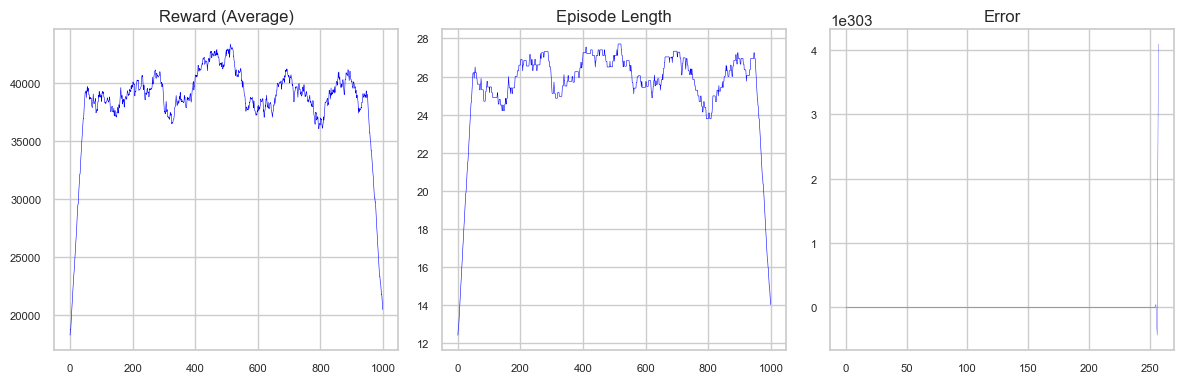

In [16]:
plt_results_(nenv, QLagent, 100)

In [8]:
action_history = []
health_level_history = []

for episode in tqdm(range(n_episodes)):
    observation, info = env.reset()
    done = False
    while not done:
        action = QLagent.policy(observation)
        s_prime, reward, terminated, truncated, info = env.step(action=action)
        
        # Store the action and health level for analysis
        action_history.append(action)
        health_level_history.append(observation["health_level"])  # Append current health level
        
        QLagent.update(observation, action, reward, s_prime)
        done = terminated or truncated
        observation = s_prime
    QLagent.decay_epsilon()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 91.34it/s]


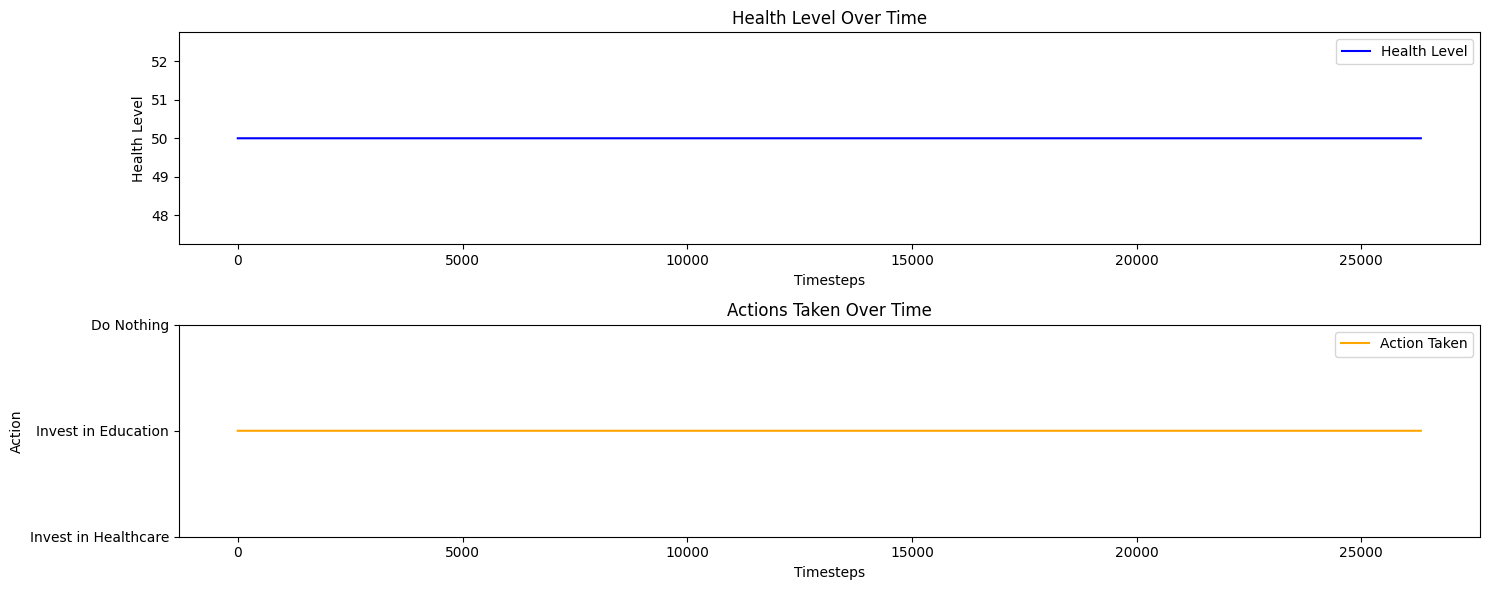

In [9]:
plt.figure(figsize=(15, 6))

# Plotting the health levels
plt.subplot(2, 1, 1)
plt.plot(health_level_history, label='Health Level', color='blue')
plt.title('Health Level Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Health Level')
plt.legend()

# Plotting the actions taken (0: invest in healthcare, 1: invest in education, 2: do nothing)
plt.subplot(2, 1, 2)
plt.plot(action_history, label='Action Taken', color='orange')
plt.title('Actions Taken Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Action')
plt.yticks([0, 1, 2], ['Invest in Healthcare', 'Invest in Education', 'Do Nothing'])
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
state_size = len(env.observation_space.spaces) 
action_size = env.action_space.n

In [11]:
DQL_agent = HealthcareDQL(
    environment=env,
    state_size=state_size,
    action_size=action_size,
    learning_rate=learning_rate,
    gamma=gamma,
    epsilon=epsilon,
    final_epsilon=final_epsilon,
    epsilon_decay=epsilon_decay
)

C:\Users\miche\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
state, info = env.reset()

# Lists to store the history of budget, health level, and risk level
budget_history = []
health_level_history = []
risk_level_history = []

for _ in range(10):
    # Get the current state as a numpy array
    state_array = np.array([state['budget'][0], state['health_level'], state['risk_level']])
    action = DQL_agent.act(state_array)

    # Take a step in the environment
    s_prime, reward, terminated, truncated, info = env.step(action=action)

    # Append the current state values to the history lists
    budget_history.append(state['budget'][0])
    health_level_history.append(state['health_level'])
    risk_level_history.append(state['risk_level'])
    print(f'Timestep: {_}, Action: {action}, Budget: {state["budget"][0]}, Health Level: {state["health_level"]}, Risk Level: {state["risk_level"]}')

    if terminated or truncated:
        print(f'Final state: {s_prime}')
        print("End of simulation")
        state, info = env.reset()
        break
    else:
        state = s_prime

env.close()

Timestep: 0, Action: 0, Budget: 1000.0, Health Level: 50, Risk Level: 50
Timestep: 1, Action: 0, Budget: 998.0, Health Level: 100, Risk Level: 50
Timestep: 2, Action: 1, Budget: 996.0, Health Level: 100, Risk Level: 50
Timestep: 3, Action: 1, Budget: 995.0, Health Level: 100, Risk Level: 52
Timestep: 4, Action: 0, Budget: 994.0, Health Level: 100, Risk Level: 51
Timestep: 5, Action: 1, Budget: 992.0, Health Level: 100, Risk Level: 51
Timestep: 6, Action: 0, Budget: 991.0, Health Level: 100, Risk Level: 50
Timestep: 7, Action: 0, Budget: 989.0, Health Level: 100, Risk Level: 50
Timestep: 8, Action: 0, Budget: 987.0, Health Level: 100, Risk Level: 50
Timestep: 9, Action: 0, Budget: 985.0, Health Level: 100, Risk Level: 50


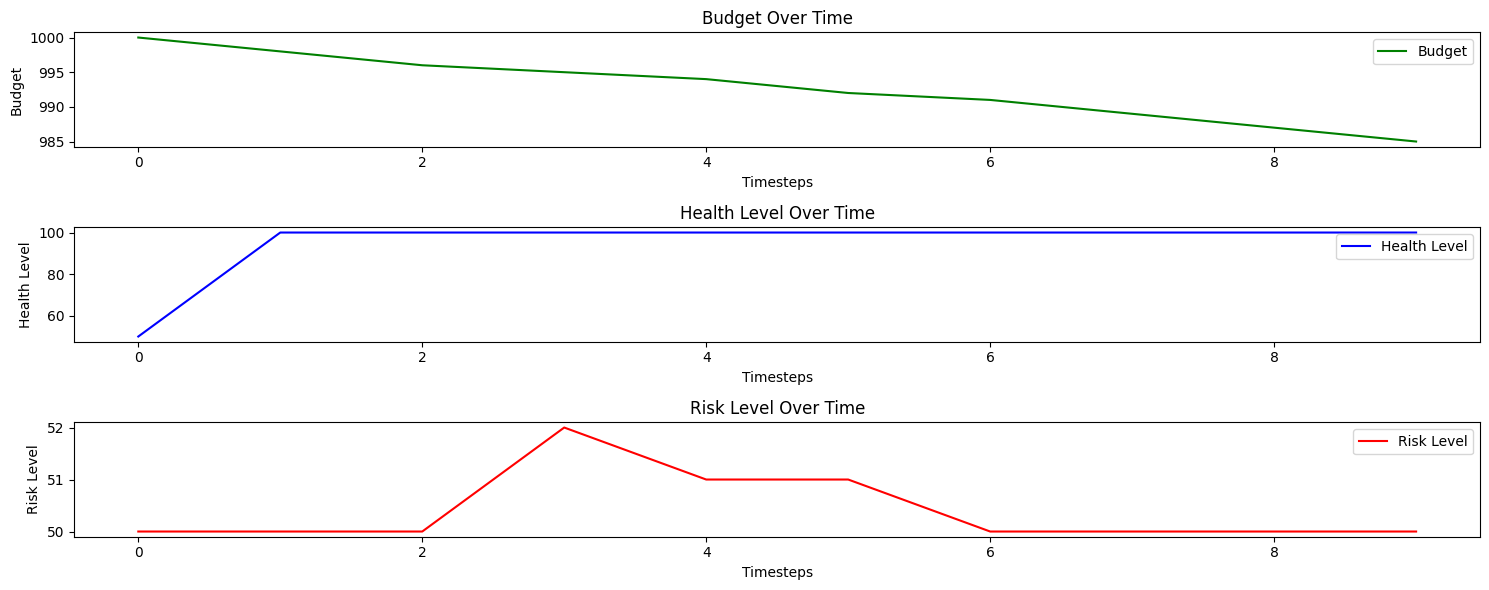

In [13]:
plt.figure(figsize=(15, 6))

# Budget Plot
plt.subplot(3, 1, 1)
plt.plot(budget_history, label='Budget', color='green')
plt.title('Budget Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Budget')
plt.legend()

# Health Level Plot
plt.subplot(3, 1, 2)
plt.plot(health_level_history, label='Health Level', color='blue')
plt.title('Health Level Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Health Level')
plt.legend()

# Risk Level Plot
plt.subplot(3, 1, 3)
plt.plot(risk_level_history, label='Risk Level', color='red')
plt.title('Risk Level Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Risk Level')
plt.legend()

plt.tight_layout()
plt.show()